There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

# Report
1. Gender, Country, and all of the time categories needed to be converted to numeric values.
2. Age had such a huge range (18-85), I decided to break it up into 3 categories (17-45, 46-65, 66-86)
3. Using WCSS I determined the optimal number of clusters would be 3.
4. Running the model with the Age Range feature as the Y value was the most informative, although it's no shock, age is absolutely the biggest deciding factor in the race, as the number of kilometers increases, the older age category (catagory 3, 66-86) gets slower and slower.
5. I was wondering how the division feature was decided, this seems to have been done based on age also.
6. The clusters generally are decided by the various time features, cluster one are the fastest runners, cluster zero the slowest, and cluster two are the mid-range runners.
6. Running this using K-Means is probably going to be the most informative, I tried using MeanShift with the data, it created 44 clusters, an absolute pain to interpret.


In [1]:
import numpy as np
import pandas as pd
import scipy
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline



In [2]:
df = pd.read_csv("results_2017.csv")


In [3]:
df.head()

,Unnamed: 0,Bib,Name,Age,M/F,City,State,Country,Citizen,Unnamed: 9,...,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender,Division
0,0,11,"Kirui, Geoffrey",24,M,Keringet,NaN,KEN,NaN,NaN,...,1:16:59,1:33:01,1:48:19,2:02:53,0:04:57,-,2:09:37,1,1,1
1,1,17,"Rupp, Galen",30,M,Portland,OR,USA,NaN,NaN,...,1:16:59,1:33:01,1:48:19,2:03:14,0:04:58,-,2:09:58,2,2,2
2,2,23,"Osako, Suguru",25,M,Machida-City,NaN,JPN,NaN,NaN,...,1:17:00,1:33:01,1:48:31,2:03:38,0:04:59,-,2:10:28,3,3,3
3,3,21,"Biwott, Shadrack",32,M,Mammoth Lakes,CA,USA,NaN,NaN,...,1:17:00,1:33:01,1:48:58,2:04:35,0:05:03,-,2:12:08,4,4,4
4,4,9,"Chebet, Wilson",31,M,Marakwet,NaN,KEN,NaN,NaN,...,1:16:59,1:33:01,1:48:41,2:05:00,0:05:04,-,2:12:35,5,5,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 25 columns):
Unnamed: 0       26410 non-null int64
Bib              26410 non-null object
Name             26410 non-null object
Age              26410 non-null int64
M/F              26410 non-null object
City             26410 non-null object
State            22815 non-null object
Country          26410 non-null object
Citizen          1254 non-null object
Unnamed: 9       91 non-null object
5K               26410 non-null object
10K              26410 non-null object
15K              26410 non-null object
20K              26410 non-null object
Half             26410 non-null object
25K              26410 non-null object
30K              26410 non-null object
35K              26410 non-null object
40K              26410 non-null object
Pace             26410 non-null object
Proj Time        26410 non-null object
Official Time    26410 non-null object
Overall          26410 non-null int64
G

In [5]:
df = df.drop(['Unnamed: 0', 'Unnamed: 9', 'Citizen', 'State', 'City', 'Bib', 'Proj Time'], axis=1)

In [6]:
df.head()

,Name,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Pace,Official Time,Overall,Gender,Division
0,"Kirui, Geoffrey",24,M,KEN,0:15:25,0:30:28,0:45:44,1:01:15,1:04:35,1:16:59,1:33:01,1:48:19,2:02:53,0:04:57,2:09:37,1,1,1
1,"Rupp, Galen",30,M,USA,0:15:24,0:30:27,0:45:44,1:01:15,1:04:35,1:16:59,1:33:01,1:48:19,2:03:14,0:04:58,2:09:58,2,2,2
2,"Osako, Suguru",25,M,JPN,0:15:25,0:30:29,0:45:44,1:01:16,1:04:36,1:17:00,1:33:01,1:48:31,2:03:38,0:04:59,2:10:28,3,3,3
3,"Biwott, Shadrack",32,M,USA,0:15:25,0:30:29,0:45:44,1:01:19,1:04:45,1:17:00,1:33:01,1:48:58,2:04:35,0:05:03,2:12:08,4,4,4
4,"Chebet, Wilson",31,M,KEN,0:15:25,0:30:28,0:45:44,1:01:15,1:04:35,1:16:59,1:33:01,1:48:41,2:05:00,0:05:04,2:12:35,5,5,5


In [7]:
df.describe()

,Age,Overall,Gender,Division
count,26410.000000,26410.000000,26410.000000,26410.000000
mean,42.587732,13206.260091,6660.973230,1588.796706
std,11.419467,7624.370496,3910.031525,1423.199500
min,18.000000,1.000000,1.000000,1.000000
25%,34.000000,6604.250000,3302.250000,502.000000
50%,43.000000,13206.500000,6603.500000,1154.000000
75%,51.000000,19808.750000,9904.750000,2190.750000
max,84.000000,26411.000000,14438.000000,5846.000000


In [8]:
df = df.replace('-', '0', regex=True)
df = df.replace(':', '', regex=True)
#df['laterthan30'] = pd.Series(np.where(df.ArrDelay > 30, 1, 0))
agebins = [17, 45, 65, 100,]
df['Age Range'] = pd.cut(df['Age'], agebins, labels=(1,2,3,))
df.rename(columns={'Gender':'Gen Place'}, inplace=True)



#df.columns.str.replace('-' , '')
#df.columns.str.replace(':' , '')

In [9]:
df.describe()

,Age,Overall,Gen Place,Division
count,26410.000000,26410.000000,26410.000000,26410.000000
mean,42.587732,13206.260091,6660.973230,1588.796706
std,11.419467,7624.370496,3910.031525,1423.199500
min,18.000000,1.000000,1.000000,1.000000
25%,34.000000,6604.250000,3302.250000,502.000000
50%,43.000000,13206.500000,6603.500000,1154.000000
75%,51.000000,19808.750000,9904.750000,2190.750000
max,84.000000,26411.000000,14438.000000,5846.000000


In [10]:
# gives some infos on columns types and number of null values
datainfo=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
datainfo=datainfo.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
datainfo=datainfo.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
datainfo

,Name,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Pace,Official Time,Overall,Gen Place,Division,Age Range
column type,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,category
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# to change use .astype() 
df['5K'] = df['5K'].astype(int)
df['10K'] = df['10K'].astype(int)
df['15K'] = df['15K'].astype(int)
df['20K'] = df['20K'].astype(int)
df['25K'] = df['25K'].astype(int)
df['30K'] = df['30K'].astype(int)
df['35K'] = df['35K'].astype(int)
df['40K'] = df['40K'].astype(int)
df['Pace'] = df['Pace'].astype(int)
df['Official Time'] = df['Official Time'].astype(int)
df['Age Range'] = df['Age Range'].astype(int)
timebins = [20930, 35139, 45000, 75816]
df['Official Time Category'] = pd.cut(df['Official Time'], timebins, labels=(1,2,3,))
df['Official Time Category'] = df['Official Time Category'].astype(int)
df['CountryCode'] = pd.factorize(df['Country'])[0]
df['Gender'] = pd.factorize(df['M/F'])[0]


In [59]:


X = df[['5K', '10K', '15K', '20K', '25K', '30K', '35K','40K',
        'Pace', 'Overall', 'Division', 'CountryCode', 'Official Time Category', 'Gen Place']]

y = df['Age Range']

In [59]:
'''

X = df[['5K', '10K', '15K', '20K', '25K', '30K', '35K','40K', Age,
        'Pace', 'Overall', 'Division', 'CountryCode', 'Official Time Category', 'Gen Place']]
y = df['Gender']

'''

In [59]:
'''

X = df[['5K', '10K', '15K', '20K', '25K', '30K', '35K','40K', Age,
        'Pace', 'Overall', 'Division', 'CountryCode', 'Gender' , 'Gen Place']]
y = df['Official Time Category']

'''

In [13]:
df.head()

,Name,Age,M/F,Country,5K,10K,15K,20K,Half,25K,...,40K,Pace,Official Time,Overall,Gen Place,Division,Age Range,Official Time Category,CountryCode,Gender
0,"Kirui, Geoffrey",24,M,KEN,1525,3028,4544,10115,10435,11659,...,20253,457,20937,1,1,1,1,1,0,0
1,"Rupp, Galen",30,M,USA,1524,3027,4544,10115,10435,11659,...,20314,458,20958,2,2,2,1,1,1,0
2,"Osako, Suguru",25,M,JPN,1525,3029,4544,10116,10436,11700,...,20338,459,21028,3,3,3,1,1,2,0
3,"Biwott, Shadrack",32,M,USA,1525,3029,4544,10119,10445,11700,...,20435,503,21208,4,4,4,1,1,1,0
4,"Chebet, Wilson",31,M,KEN,1525,3028,4544,10115,10435,11659,...,20500,504,21235,5,5,5,1,1,0,0


In [14]:
X.head()

,5K,10K,15K,20K,25K,30K,35K,40K,Pace,Overall,Division,CountryCode,Official Time Category,Gen Place
0,1525,3028,4544,10115,11659,13301,14819,20253,457,1,1,0,1,1
1,1524,3027,4544,10115,11659,13301,14819,20314,458,2,2,1,1,2
2,1525,3029,4544,10116,11700,13301,14831,20338,459,3,3,2,1,3
3,1525,3029,4544,10119,11700,13301,14858,20435,503,4,4,1,1,4
4,1525,3028,4544,10115,11659,13301,14841,20500,504,5,5,0,1,5


In [15]:
X.describe()

,5K,10K,15K,20K,25K,30K,35K,40K,Pace,Overall,Division,CountryCode,Official Time Category,Gen Place
count,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000,26410.000000
mean,2533.763802,5666.992806,11543.213177,15108.648618,20182.324953,25068.142295,30223.985574,35426.086179,888.968194,13206.260091,1588.796706,4.366869,1.624006,6660.973230
std,405.714703,2080.586015,1772.215859,3085.191789,4222.499241,4740.351551,5986.466445,6777.684653,161.166495,7624.370496,1423.199500,9.406643,0.694732,3910.031525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,457.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,2241.000000,4526.000000,10840.000000,13231.000000,15650.000000,22224.000000,24915.000000,31634.000000,757.000000,6604.250000,502.000000,1.000000,1.000000,3302.250000
50%,2504.000000,5011.000000,11545.000000,14205.000000,20906.000000,23804.000000,30825.000000,33839.000000,851.000000,13206.500000,1154.000000,1.000000,1.500000,6603.500000
75%,2745.000000,5533.000000,12357.000000,15332.000000,22437.000000,25748.000000,33232.750000,40659.000000,1000.000000,19808.750000,2190.750000,1.000000,2.000000,9904.750000
max,5414.000000,14522.000000,23236.000000,32325.000000,42714.000000,53713.000000,63907.000000,74123.000000,1815.000000,26411.000000,5846.000000,90.000000,3.000000,14438.000000


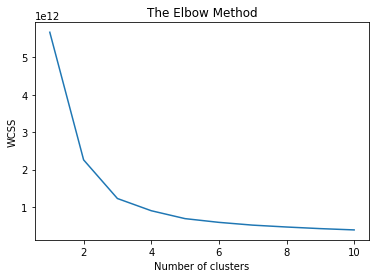

In [16]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [17]:
#X['Division'].groupby(X['Division'], axis=0).count()

In [18]:
# gives some infos on columns types and number of null values
datainfo=pd.DataFrame(X.dtypes).T.rename(index={0:'column type'})
datainfo=datainfo.append(pd.DataFrame(X.isnull().sum()).T.rename(index={0:'null values (nb)'}))
datainfo=datainfo.append(pd.DataFrame(X.isnull().sum()/X.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
datainfo

,5K,10K,15K,20K,25K,30K,35K,40K,Pace,Overall,Division,CountryCode,Official Time Category,Gen Place
column type,int32,int32,int32,int32,int32,int32,int32,int32,int32,int64,int64,int64,int32,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
X.head()

,5K,10K,15K,20K,25K,30K,35K,40K,Pace,Overall,Division,CountryCode,Official Time Category,Gen Place
0,1525,3028,4544,10115,11659,13301,14819,20253,457,1,1,0,1,1
1,1524,3027,4544,10115,11659,13301,14819,20314,458,2,2,1,1,2
2,1525,3029,4544,10116,11700,13301,14831,20338,459,3,3,2,1,3
3,1525,3029,4544,10119,11700,13301,14858,20435,503,4,4,1,1,4
4,1525,3028,4544,10115,11659,13301,14841,20500,504,5,5,0,1,5


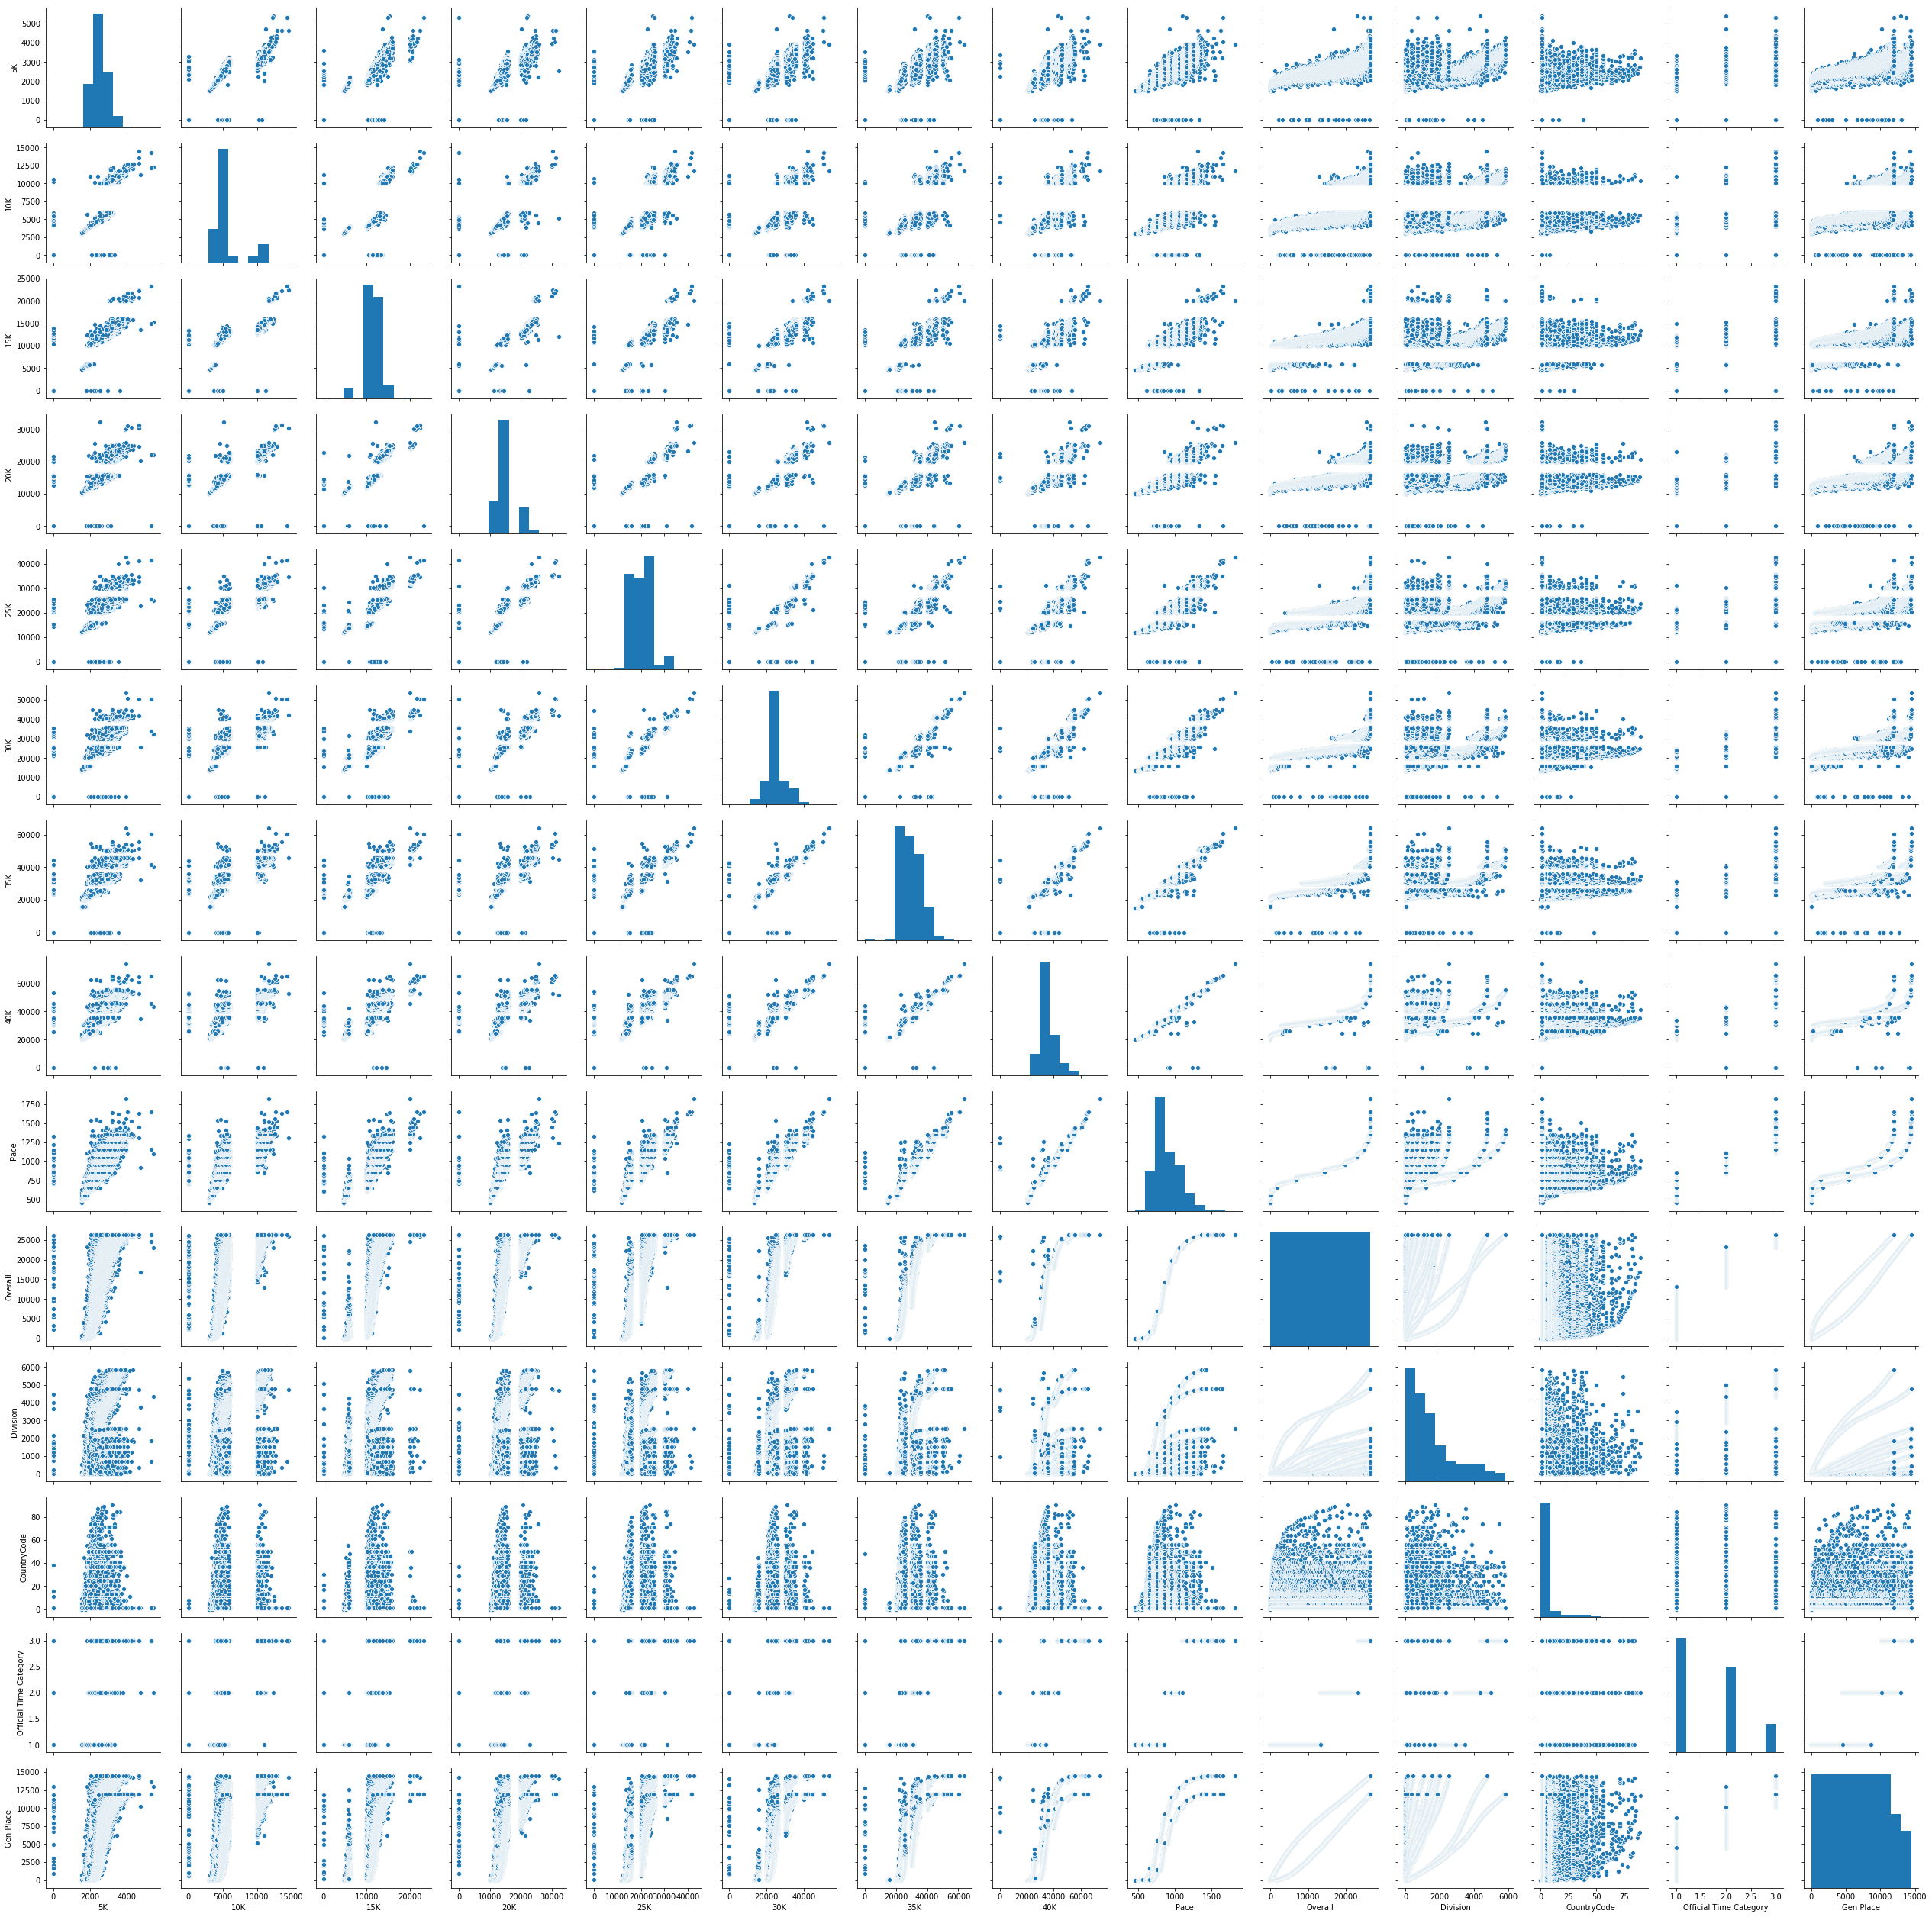

In [20]:
sns.pairplot(X)

In [21]:
print(len(df[df['5K'] == 0]))

25


In [22]:
male = df[df['Gender'] == 0]
female = df[df['Gender'] == 1]

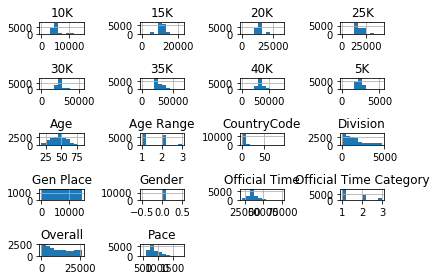

In [23]:
male.hist()
plt.tight_layout()

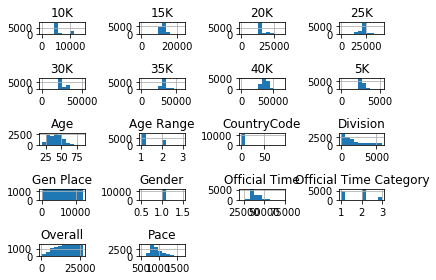

In [24]:
female.hist()
plt.tight_layout()

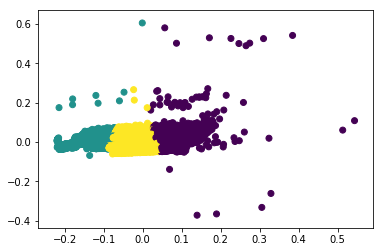

Comparing k-means clusters against the data:
Age Range     1     2    3
row_0                     
0          5742  5912  516
1          5502  1411    3
2          4345  2942   37


In [48]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

In [56]:
kn = KMeans(n_clusters=3, random_state=42).fit(X_pca)

In [57]:
df['labels'] = kn.labels_

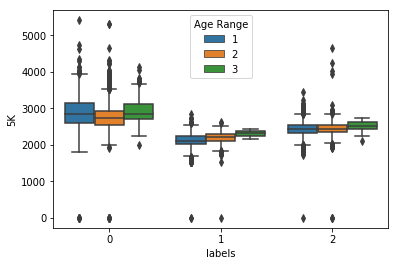

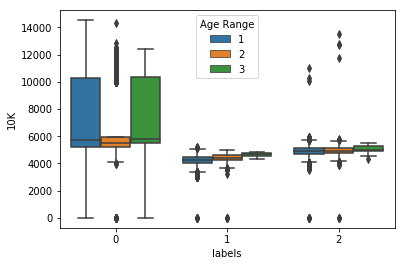

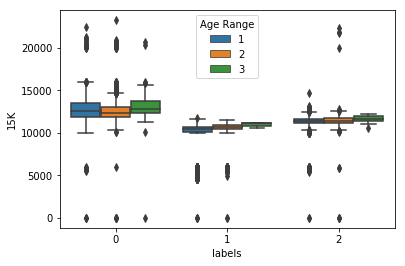

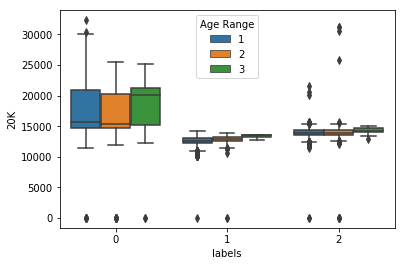

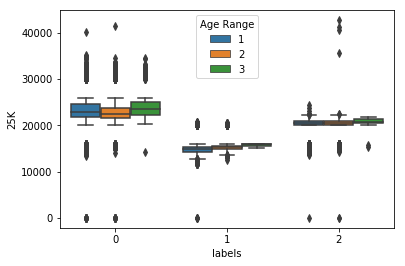

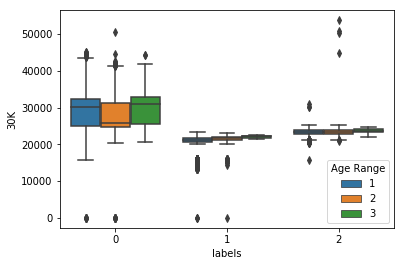

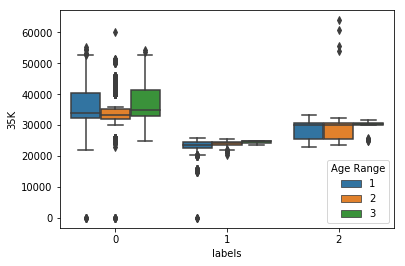

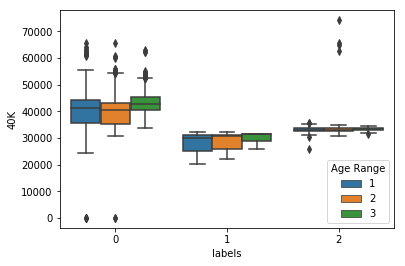

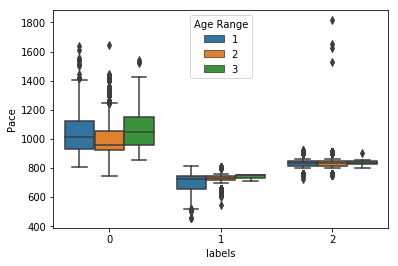

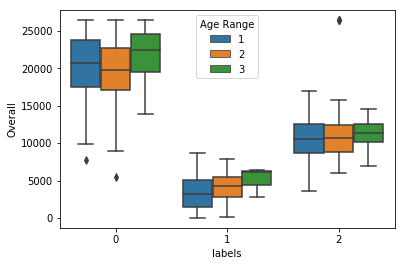

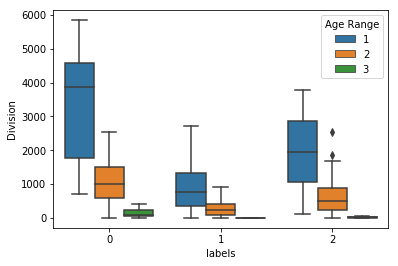

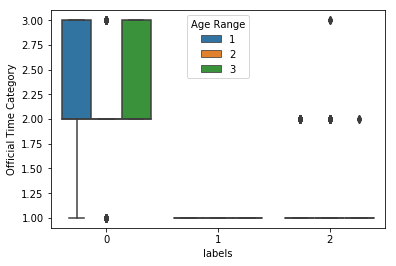

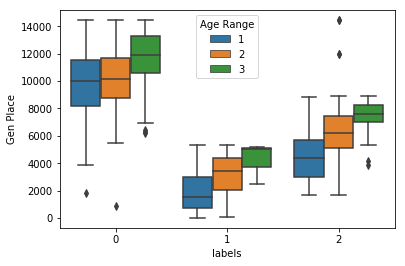

In [60]:
for i in X.drop(['CountryCode'], 1).columns:
    sns.boxplot(x='labels', y=i, data=df, hue='Age Range')
    plt.show()
#sns.boxplot(x='labels', y='Overall', data=df, hue='Age Range')

Same data, but with MeanShift

In [52]:
X = normalize(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42)

In [54]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 44


In [55]:
#plt.scatter(X_train['Official Time'], X_train['CountryCode'], c=labels)
#plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(labels, y_train))

Comparing the assigned categories to the ones in the data:
Age Range     1     2    3
row_0                     
0          5629  5644  421
1          5057  2378   18
2          1654   200    0
3            32     0    0
4             7     5    0
5             1     8    1
6             2     4    0
7             0     4    0
8            11     2    0
9             1     1    0
10            2     0    0
11            2     0    0
12            1     1    0
13            1     0    0
14            1     0    0
15            0     1    0
16            0     1    0
17            1     0    0
18            1     0    0
19            0     1    0
20            1     0    0
21            1     0    0
22            1     0    0
23            1     0    0
24            0     1    0
25            0     1    0
26            0     1    0
27            1     0    0
28            0     1    0
29            2     0    0
30            1     0    0
31            1     0    0
32            0     1  

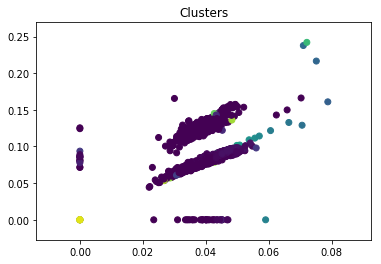

In [40]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.title('Clusters')
plt.show()